# Train and evaluate graphs

We can use the pytorch geometric library to make a graph model that can perform classification on different nodes in the graph. [link](https://pytorch-geometric.readthedocs.io/en/latest/)

The graph created is the same as the one described in the paper of David P. et al [link](https://arxiv.org/pdf/2107.14756.pdf). We work with the pytorch geometric library to have acess to more recent algorithms that run on graphs.

The graph contains two different node types. One node for each ip corresponding to a device and a node for each connection between ip's. Graphs with multiple node types are called heterogenous graphs. 

We use a transformer based graph neural network designed for heterogenous graphs and implemented in the pytorch geometric library, more details can be found in this paper
[link](https://arxiv.org/abs/2003.01332)

In [1]:
import pickle

with open('data/train/week1_prep_train.pkl','rb') as f:
    df_train = pickle.load(f)

with open('data/eval/week1_prep_val.pkl','rb') as f:
    df_test = pickle.load(f)

We define a class to convert the tabular data to graphs. For each node of type 'ip' corresponding to a device we add a feature based on the ip-adress. For each subnet in the network we create a column and convert ip adresses to a category, this can be seen in the function `encode_ip`.

The nodes of type 'connection' contain a number of connection type features defined in the constructor of the class, see `self.conn_feat`. Each connection node also contains a label see `self.labels_cols_oh`.

This way we can train an algorithm to classify the connection nodes that also use information from the structure of the graph and ip nodes. Such a graph is created in pieces for example of 200 rows of our tabular dataset, each row contains information about a connection between two devices. In this way we create a snapshot of the network. This is done in the function `process`

In [2]:
#zelf grafen aanmaken per 200 connecties
from torch_geometric.data import HeteroData
from torch_geometric.loader import DataLoader
import numpy as np
import torch
from tqdm import tqdm
import pickle

class CICdata():
    def __init__(self, path_data):
        f = open(path_data,'rb')
        self.df = pickle.load(f)
        self.conn_feat = ['Duration', 'Packets', 'Bytes', 'Proto_ICMP ', 'Proto_IGMP ','Proto_TCP  ', 'Proto_UDP  ','flag_A', 'flag_P', 'flag_R', 'flag_S','flag_F', 'Tos_0', 'Tos_16', 'Tos_32', 'Tos_192']
        self.label_cols_oh = ['attack_benign','attack_bruteForce', 'attack_dos', 'attack_pingScan', 'attack_portScan']
        
        
    def make_ip_map(self, data):
        unique_ip = np.unique(np.append(data['Src IP Addr'].to_numpy(), 
                                        data['Dst IP Addr'].to_numpy()))
        return {ip:idx for idx, ip in enumerate(unique_ip)}
    
    def encode_ip(self, value):
        temp = [0]*10
        if value == '192.168.100.6': #internal web server
            temp[0] = 1.0
        elif value == '192.168.100.5': #internal file server
            temp[1] = 1.0
        elif value == '192.168.100.4': #internal mail server
            temp[2] = 1.0
        elif value == '192.168.100.3': #internal backup server
            temp[3] = 1.0
        elif value[:11] == '192.168.100': #server subnet
            temp[4] = 1.0
        elif value[:11] == '192.168.200': #management subnet
            temp[5] = 1.0
        elif value[:11] == '192.168.210': #office subnet
            temp[6] = 1.0
        elif value[:11] == '192.168.220': #developer subnet
            temp[7] = 1.0
        elif value[5:6]=='_': #public ip
            temp[8] = 1.0
        elif value in ['0.0.0.0', '255.255.255.255']: #local ip
            temp[9] = 1.0

        return temp
    
    def get_ip_feat(self, ip_map):
        ip_data = []
        for ip, idx in ip_map.items():
            ip_data.append(self.encode_ip(ip))
        
        return torch.tensor(ip_data).float()
                
    def make_edges(self, data, ip_map):
        src = []
        dst = []
        count = 0
        for _, row in data.iterrows():
            #source ip to connection
            src.append(ip_map[row['Src IP Addr']])
            dst.append(count)

            #destination ip to connection
            src.append(ip_map[row['Dst IP Addr']])
            dst.append(count)
            count +=1

        return torch.tensor([src, dst]), torch.tensor([dst, src])

    def get_info_conn(self, data, cols):
        return torch.tensor(data[cols].values)
                
    def process(self, n_rows=200):
        x_conn = self.get_info_conn(self.df, self.conn_feat)
        y = self.get_info_conn(self.df, self.label_cols_oh)
        data_list = []
        for i in tqdm(range(1, (len(self.df)//n_rows)+1), desc='processing'):
            start_idx = (i-1)*n_rows
            end_idx = i*n_rows
            sample = self.df[start_idx:end_idx]
            ip_map = self.make_ip_map(sample)
            ip_to_conn, conn_to_ip = self.make_edges(sample, ip_map)
            data = HeteroData()
            data['ip'].x = self.get_ip_feat(ip_map) #encode ip's from the map
            data['connection'].x = x_conn[start_idx:end_idx].float()
            data['connection'].y = y[start_idx:end_idx]
            data['ip','connection'].edge_index = ip_to_conn
            data['connection','ip'].edge_index = conn_to_ip
            data_list.append(data)
        
        return data_list

/home/aaron/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cic_data = CICdata('data/train/week1_prep_train.pkl')

In [4]:
data = cic_data.process()

processing: 100%|██████████| 10559/10559 [01:17<00:00, 136.87it/s]


We can display the types of nodes in our dataset along with the edges.
* two node types: 'ip' and 'connection'.
* two edge types: from ip to connection node or from connection to ip node.

In [5]:
print(data[0].node_types)
print(data[0].metadata())

['ip', 'connection']
(['ip', 'connection'], [('ip', 'to', 'connection'), ('connection', 'to', 'ip')])


A heterogenous graph transformer model can be easily made by using built-in classes. Some hyperparameters can be chosen such as the number of heads, hidden channels and number of layers.

The number of out channels is always the number of unique label values (5 in the example dataset).

In [6]:
import torch_geometric.transforms as T
from torch_geometric.nn import HGTConv, Linear

class HGT(torch.nn.Module):
    def __init__(self, data_graph, hidden_channels, out_channels, num_heads, num_layers):
        super().__init__()

        self.lin_dict = torch.nn.ModuleDict()
        for node_type in data_graph.node_types:
            self.lin_dict[node_type] = Linear(-1, hidden_channels)

        print(self.lin_dict)
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, data_graph.metadata(),
                           num_heads, group='sum')
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):        
        for node_type, x in x_dict.items():
            x_dict[node_type] = self.lin_dict[node_type](x).relu_()

        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)

        return self.lin(x_dict['connection'])

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = HGT(data_graph= data[0], hidden_channels=64, out_channels=5,
            num_heads=4, num_layers=2)
# Initialize lazy module, still on cpu
with torch.no_grad():
    out = model(data[0].x_dict, data[0].edge_index_dict)

ModuleDict(
  (ip): Linear(-1, 64, bias=True)
  (connection): Linear(-1, 64, bias=True)
)


The algorithm is trained with boilerplate pytorch code. The number of epochs and batch size can be adapted.

In [8]:
from torch_geometric.loader import DataLoader, DataListLoader
from torch.optim import Adam
from torch.nn import functional as F
from torch import nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#hyperparams
EPOCHS = 20
batch_size = 64

optimizer = Adam(model.parameters())
train_loader = DataLoader(data, batch_size=batch_size)


def train():
    model.to(device)
    model.train()
    for epoch in range(EPOCHS):
        total_examples = total_loss = 0

        for batch in train_loader:
            optimizer.zero_grad()
            batch.to(device)
            out = model(batch.x_dict, batch.edge_index_dict)
            #print(batch['connection'].y, batch['connection'].y.size())
            # print(out, out.size())
            loss = F.cross_entropy(out, batch['connection'].y.float())
            #loss = focal_loss(out, batch['connection'].y.float())
            loss.backward()
            optimizer.step()

            total_examples += 64
            total_loss += float(loss) * 64
            
        tqdm.write('EPOCH '+str(epoch)+' loss: '+ str(total_loss/total_examples))

In [9]:
train()

EPOCH 0 loss: 0.9322913706754193
EPOCH 1 loss: 0.16046471826478162
EPOCH 2 loss: 0.062281487969625175
EPOCH 3 loss: 0.014985114088366655
EPOCH 4 loss: 0.010426313102344107
EPOCH 5 loss: 0.013350125156328873
EPOCH 6 loss: 0.008677027960992277
EPOCH 7 loss: 0.007522727051466725
EPOCH 8 loss: 0.0066821399787978875
EPOCH 9 loss: 0.005868906476230636
EPOCH 10 loss: 0.005254232927505985
EPOCH 11 loss: 0.004955659348298937
EPOCH 12 loss: 0.007188951528223697
EPOCH 13 loss: 0.004633130229900196
EPOCH 14 loss: 0.004164681641475799
EPOCH 15 loss: 0.0038702172367541636
EPOCH 16 loss: 0.003631958313185764
EPOCH 17 loss: 0.0034339314269152856
EPOCH 18 loss: 0.003199040216642254
EPOCH 19 loss: 0.002980015163959913


The tabular data for evaluation is converted into graphs and predictions are made with the now trained algorithm. Notice labels are extracted from the `connection` nodes.

In [10]:
cic_val = CICdata('data/eval/week1_prep_val.pkl')
data_val = cic_val.process()

processing: 100%|██████████| 2639/2639 [00:19<00:00, 135.87it/s]


In [369]:
model.eval()
count=0
preds = []
labels = []
for graph in tqdm(data_val):
    graph.to(device)
    preds.append(model(graph.x_dict, graph.edge_index_dict).argmax(dim=1))
    labels.append(graph['connection'].y.argmax(dim=1))

preds = torch.cat(preds)
labels = torch.cat(labels)

100%|██████████| 2639/2639 [00:20<00:00, 131.54it/s]


In [12]:
#precise calculation of accuracy
correct = (preds == labels).sum()
acc = correct / len(preds)
acc

tensor(0.9969, device='cuda:0')

The label values were one-hot encoded. The numbers [0, 1, 2, 3, 4] correspond to the different classes. We can convert these back

In [13]:
from sklearn.metrics import classification_report
print(classification_report(preds.cpu(), labels.cpu()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    323275
           1       1.00      0.37      0.54       985
           2       1.00      1.00      1.00    155994
           3       0.35      0.58      0.44       848
           4       0.99      0.99      0.99     46698

    accuracy                           1.00    527800
   macro avg       0.87      0.79      0.79    527800
weighted avg       1.00      1.00      1.00    527800



In [14]:
import pandas as pd
map_class = {'0':'benign', '1':'bruteforce', '2':'dos', '3':'pingscan', '4':'portscan'}
cr_df = pd.DataFrame(classification_report(preds.cpu(), labels.cpu(), output_dict=True)).transpose()
temp = cr_df.index[:5].map(map_class).append(cr_df.index[5:])
cr_df.index = temp
cr_df

,precision,recall,f1-score,support
benign,0.999357,0.999988,0.999672,323275.000000
bruteforce,1.000000,0.369543,0.539659,985.000000
dos,0.999987,0.999808,0.999897,155994.000000
pingscan,0.353528,0.584906,0.440693,848.000000
portscan,0.988602,0.986274,0.987436,46698.000000
accuracy,0.996878,0.996878,0.996878,0.996878
macro avg,0.868295,0.788104,0.793472,527800.000000
weighted avg,0.997555,0.996878,0.996900,527800.000000


The results clearly show the `bruteforce` and `pingscan` attacks are much harder to detect. They also occur much less in the dataset according to the support column.

### Visualization & explanation

We can extract some information of the graphs to visualize connections in the network and connections predicted as part of an attack.

We can also list the properties of connections that are predicted as part of an attack and related devices.

Each graph in our dataset contains 200 connections default we can take a sub-sample of the graph by looking at the neighbours of ip-type nodes.

In [384]:
from torch_geometric.loader import NeighborLoader

#indexes in dataset for different scenario's
examples = {'portscan':2, 'bruteforce':1222, 'dos':2000, 'pingscan':1467}

g = data_val[examples['portscan']]

nloader = NeighborLoader(
    data=g,
    # Sample all neighbors for each node and each edge type for 2 iterations:
    num_neighbors={('ip', 'to', 'connection'): [-1]*2 , ('connection', 'to', 'ip'): [-1]*2},
    input_nodes=('ip'),
    batch_size=100
)

sample = next(iter(nloader)).to('cpu')
sample

HeteroData(
  ip={
    x=[96, 10],
    input_id=[96],
    batch_size=96
  },
  connection={
    x=[200, 16],
    y=[200, 5]
  },
  (ip, to, connection)={ edge_index=[2, 400] },
  (connection, to, ip)={ edge_index=[2, 400] }
)

We can convert a HeteroData object to a networkx object to visualize this later

In [385]:
import networkx as nx
from torch_geometric.utils.convert import to_networkx

def to_networkx_graph(ptgraph):
    G = nx.Graph()
    #add ip nodes
    for i in range(ptgraph['ip'].x.shape[0]):
        G.add_node('ip_'+str(i), ip=sample['ip'].x[i])
    
    for i in range(ptgraph['connection'].x.shape[0]):
        G.add_node('conn_'+str(i), x=ptgraph['connection'].x[i], y=ptgraph['connection'].y[i].argmax().item())
        
    for ip_idx, conn_idx in ptgraph['ip','connection'].edge_index.T:
        G.add_edge('ip_'+str(ip_idx.item()), 'conn_'+str(conn_idx.item()))
    
    for conn_idx, ip_idx in ptgraph['connection','ip'].edge_index.T:
        G.add_edge('conn_'+str(conn_idx.item()), 'ip_'+str(ip_idx.item()))
    
    return G

In [386]:
G = to_networkx_graph(sample)
print(len(G.nodes))

296


This sample is visualised, malicious connections are visible with red exlamation icons.\
For some examples we can see multiple 'islands' of connections corresponding with different subnets in the network.

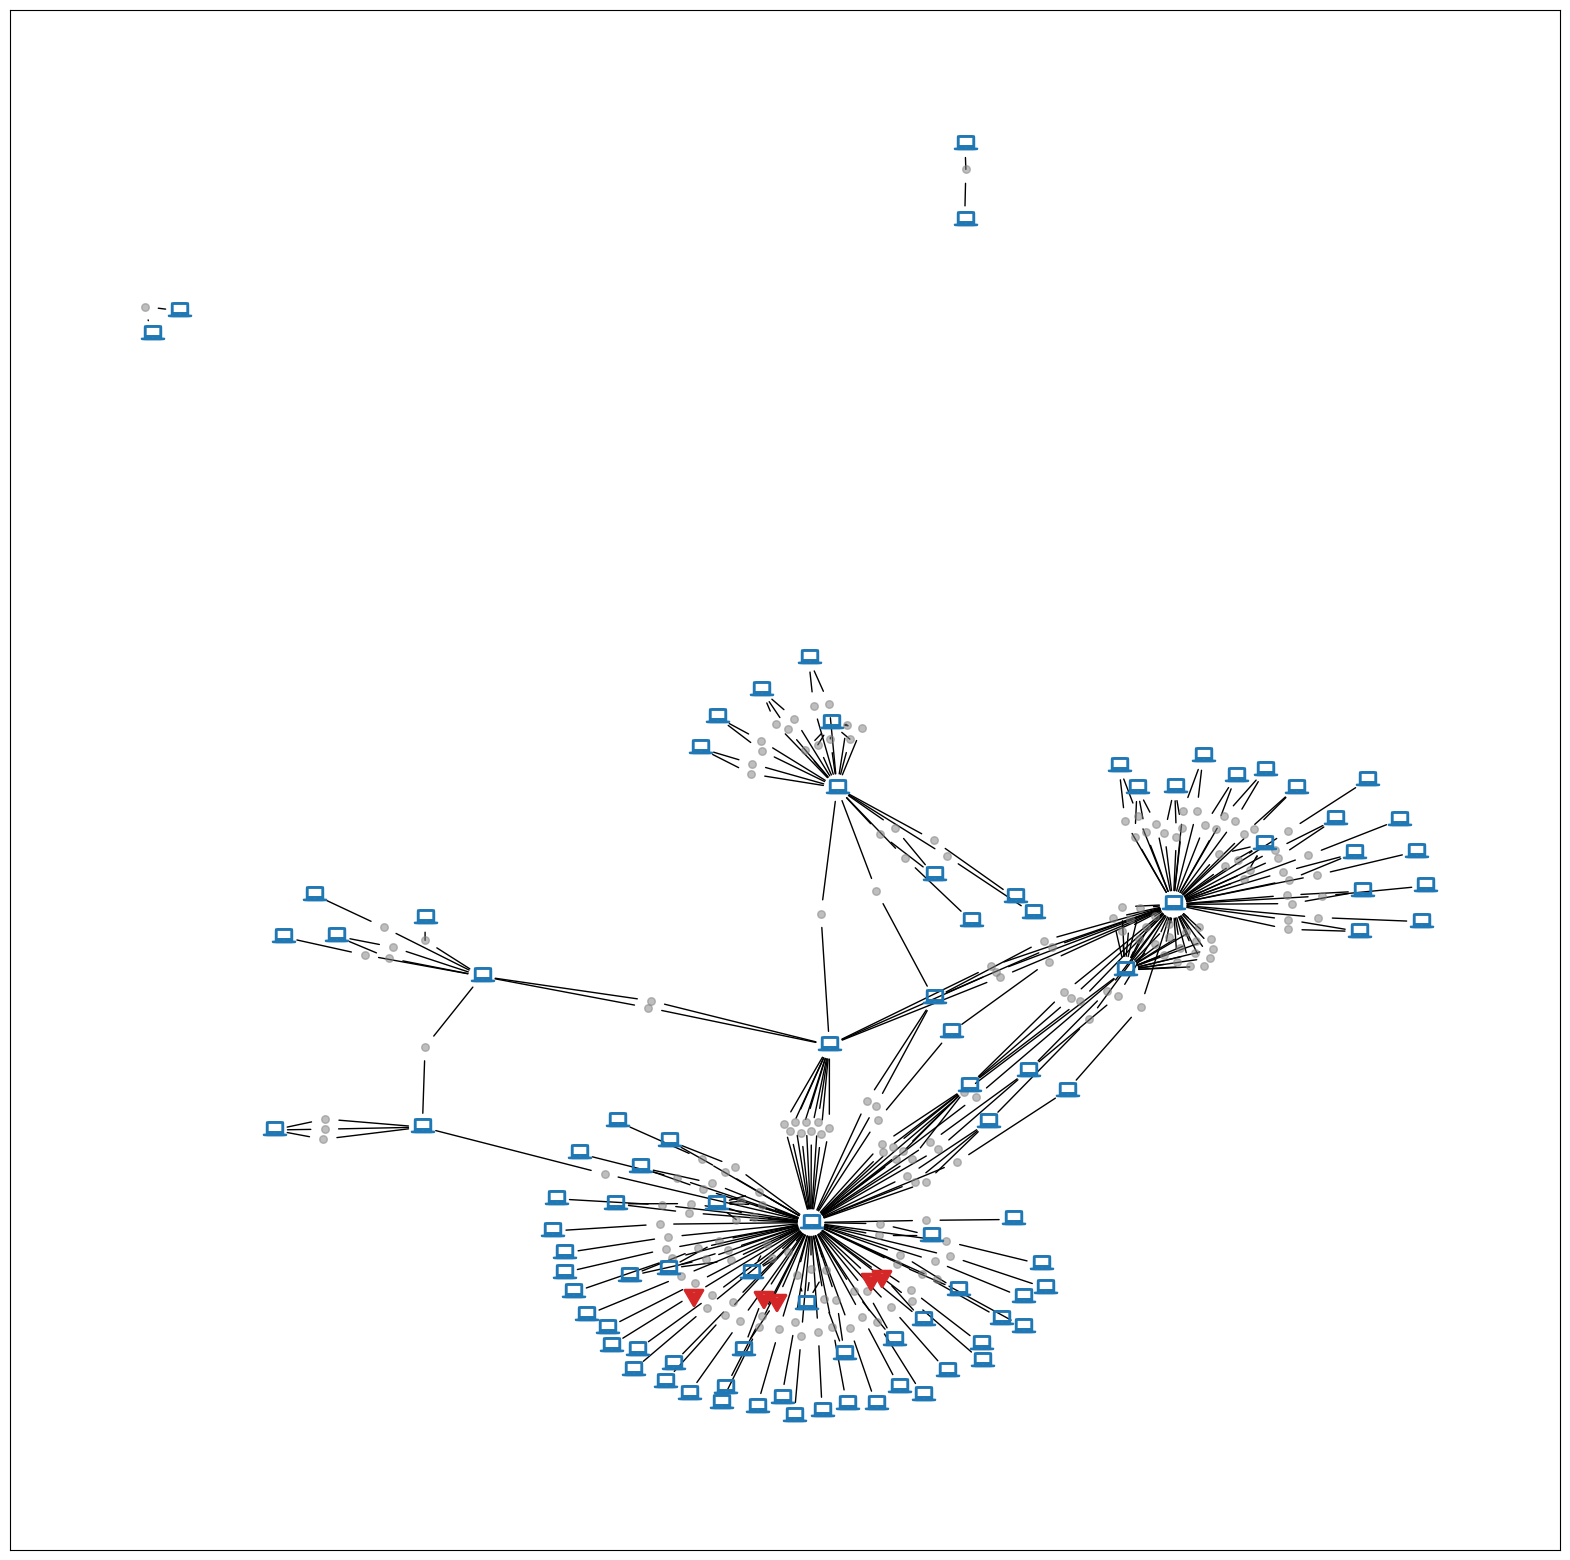

In [387]:
import matplotlib.pyplot as plt
import networkx as nx
from custom_markers import *

conns = list(filter(lambda x: x[0]=='c', list(G.nodes)))
ips = list(filter(lambda x: x[0]=='i', list(G.nodes)))

conns_attack = list(filter(lambda x: G.nodes[x]['y']!=0, conns))
conns_normal = list(filter(lambda x: G.nodes[x]['y']==0, conns))

fig = plt.figure(figsize=(20,20))
         
pos = nx.spring_layout(G)

nx.draw_networkx_edges(G, pos=pos, arrows=True,  min_source_margin=10, min_target_margin=10)
nx.draw_networkx_nodes(G, pos=pos, nodelist=conns_normal, node_color="tab:grey", alpha=0.5, node_size=30)
nx.draw_networkx_nodes(G, pos=pos, nodelist=conns_attack, node_shape=markers['malicious'], node_color="tab:red")
nx.draw_networkx_nodes(G, pos=pos, nodelist=ips, node_shape=markers['pc'], node_color="tab:blue")
plt.show()

We can also extract the malicious connections and the devices they talked to for an overview of attacks executed.

In [388]:
def describe_attacks(G, output_path=None):
    conns = list(filter(lambda x: x[0]=='c', list(G.nodes)))
    conns_attack = list(filter(lambda x: G.nodes[x]['y']!=0, conns))
    
    labels = ['attack_benign','attack_bruteForce', 'attack_dos', 'attack_pingScan', 'attack_portScan']
    subnets = ['the web server','the file server','the mail server','the backup server', 'the server subnet', 
           'the management subnet', 'the office subnet', 'the developer subnet', 'an external ip', 'a local ip']
    label_map = {idx:label for idx, label in enumerate(labels)}
    subnet_map = {idx:subnet for idx, subnet in enumerate(subnets)}
    
    ip_attack = {}
    for c in conns_attack:
        key = []
        for t in G.edges(c):
            key.append(t[1])
        key.sort()
        key = key+[label_map[G.nodes[c]['y']]]

        if tuple(key) in ip_attack.keys():
            ip_attack[tuple(key)] = ip_attack[tuple(key)]+[c]
        else:
            ip_attack[tuple(key)]=[c]
    
    for key in ip_attack.keys():
        device_a = subnet_map[G.nodes[key[0]]['ip'].argmax().item()]
        device_b = subnet_map[G.nodes[key[1]]['ip'].argmax().item()]
        label_descr = label_map[G.nodes[ip_attack[key][0]]['y']]
        explanation = f'{len(ip_attack[key])} connections between {device_a} ({key[0]}) and {device_b} ({key[1]}) predicted as {label_descr}\n'
        
        if output_path:
            with open(output_path, 'a') as f:
                f.write(explanation)
        else:
            print(explanation)

In [389]:
describe_attacks(G)

2 connections between the office subnet (ip_87) and the developer subnet (ip_92) predicted as attack_portScan

2 connections between the office subnet (ip_88) and the developer subnet (ip_92) predicted as attack_portScan

1 connections between the developer subnet (ip_92) and the developer subnet (ip_93) predicted as attack_portScan



In [390]:
#or save in file
describe_attacks(G, 'explanation.txt')